In [1]:
import numpy as np
from time import time
from math import log, sqrt, exp
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

import statsmodels.api as sm

In [2]:
# 计算的一些初始值
S_0 = 10.0    # 股票或指数初始的价格;
T = 1        #  期权的到期年限(距离到期日时间间隔)
r = 0.05       #   无风险利率

lamda = 1    # 影响波动率的固定部分
theta = -0.53    # 杠杆效应
miu = 0     # 股票价格的漂移项 ，先假设为0
N = 420      # number of time steps 210个区间
dt = T/N       # time enterval
I = 20000       # number of simulation

def bsm_call_value(S_0, K, T, r, sigma):
    S_0 = float(S_0)
    d_1 = (log(S_0 / K) + (r + 0.5 *sigma **2) *T)/(sigma * sqrt(T))
    d_2 = (log(S_0 / K) + (r - 0.5 *sigma **2) *T)/(sigma * sqrt(T))
    C_0 = (S_0 * stats.norm.cdf(d_1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d_2, 0.0, 1.0))
    return C_0

In [3]:
Me=np.mat([[1,2],[3,4],[5,6]])
print(Me.shape)
Me[:,0]

(3, 2)


matrix([[1],
        [3],
        [5]])

In [4]:
np.random.seed(2000)
#C_0=[]
#Zi=np.zeros(shape=(M+1,I))
#S_ie=np.zeros(shape=(M+1,I)) # 表示EMS方法处理过后的资产价格
S_i=np.zeros(shape=(N+1,I)) #股票价格有211天的数据
S_i[0]=S_0
start = time()
for t in range (N): # 一条路径上的节点数
    
    # 生成一个随机变量的数组，N+1行，I列
    # 同时计算出每一条路径，每一个时间点的指数水平的增量
    # np.cumsum(axis=0)，在列的方向上进行累加得到每一个时间步数上的指数水平
    #S_i = S_0 * np.exp(np.cumsum((miu) *dt +sigma *np.sqrt(dt) *np.random.standard_normal((M+1, I)),axis=0))
    for i in range (I):
        #S_i[t+1,i] = S_0 * np.exp((miu-0.5*(lamda*S_i[t,i]**(theta)**2)) *dt +lamda*S_i[t,i]**(theta)*np.sqrt(dt) *np.random.standard_normal((1, 1)))
        S_i[t+1,i] = S_i[t,i]+ (miu*S_i[t,i] +0.5*lamda**2*(theta+1)*S_i[t,i]**(2*theta+1))*dt+lamda*S_i[t,i]**(theta+1)*np.sqrt(dt)*np.random.standard_normal((1, 1))
       # S_ie[0]=S_0
        # 行数代表时间，列数代表第几个模拟值
        #for m in range(M):
       #     Zi[m]=S_ie[m]*np.array(S_i[m+1])/np.array(S_i[m])
      #      Z0=np.exp(-r * T)* np.sum(Zi[m])/I
     #       S_ie[m+1]=(S_0*Zi[m]/Z0)          
    #    C_0.append(np.exp(-r * T) * np.sum(np.maximum(np.mat(S_ie)[-1] - K, 0))/I)


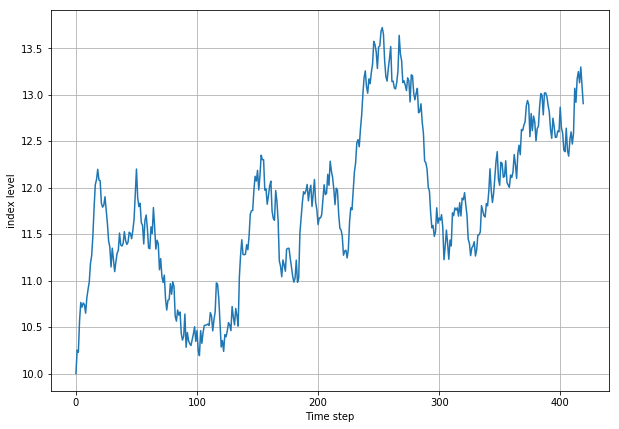

In [5]:
# 前２０条模拟路径

%matplotlib inline 
plt.figure(figsize=(10,7))
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('index level')
plt.plot(S_i[:N,:1])
plt.show()

In [6]:
#Estimation
#Estimate the standard deviation.

K=21  #方差估计的窗口期
sigma_hat=np.zeros(shape=(N-K+2,I)) #Because we do not estimate the s.d. of the first 10 and the last 10 days.初始化
r=np.zeros(shape=(N,I))    # r表示回报率
for n in range(N):
    #r[n]=np.log(np.array(S_i[n+1])/np.array(S_i[n])) #对数化求return
    r[n]=((np.array(S_i[n+1]))/np.array(S_i[n]))-1 #常规return
    
for t in range(N-K+2):
    for i in range(I):
        sigma_hat[t,i]=sqrt(sum((r[t:t+K-1,i]-sum(r[t:t+K-1,i])/K)**2)/(K-1))  
        #sigma_hat[t,i]=sqrt(sum(r[t:t+K-1,i]**2)+2*sum(r[t:t+K-2,i]*r[t+1:t+K-1,i])/(K-1))


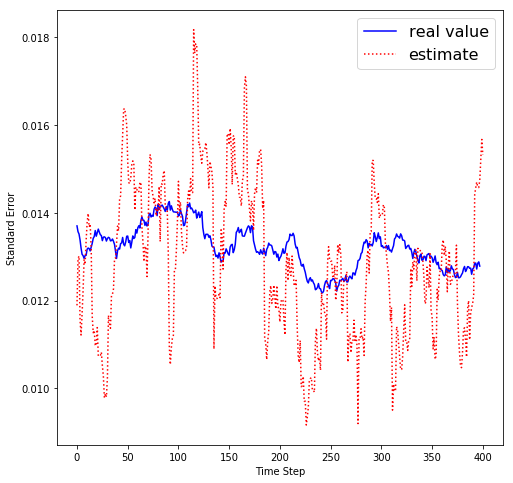

In [7]:
#Compare the estimates and the real value of standard deviation.

from collections import OrderedDict
sigma=lamda*S_i**(theta)*sqrt(dt)

a=int((K+1)/2)
b=N-int(a)
plt.figure(figsize=(8,8))
plt.xlabel('Time Step')
plt.ylabel('Standard Error')
plt.plot(sigma[a:b,:1],label='real value',color='b',linestyle='-')
plt.plot(sigma_hat[:,:1],label='estimate',color='r',linestyle=':')
handles, labels = plt.gca().get_legend_handles_labels()    ##这里是为了删去重复的图例
by_label = OrderedDict(zip(labels, handles))               ##
plt.legend(by_label.values(), by_label.keys(),fontsize=16)
plt.show()

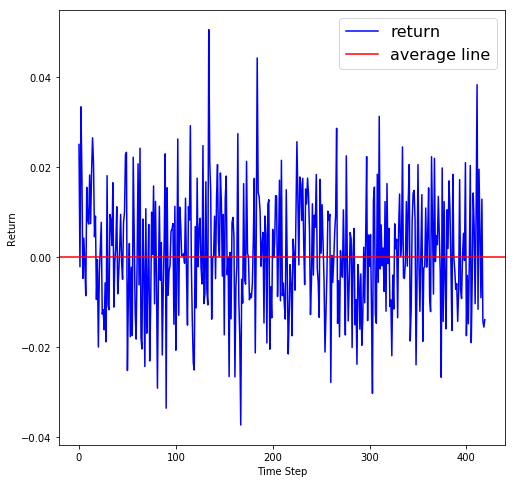

In [8]:
#回报率路径图

from collections import OrderedDict
sigma=lamda*S_i**(theta)*sqrt(dt)

a=int((K+1)/2)
b=N-int(a)
plt.figure(figsize=(8,8))
plt.xlabel('Time Step')
plt.ylabel('Return')
plt.plot(r[:,:1],label='return',color='b',linestyle='-')
plt.axhline(y=np.average(r),label='average line',color='red',linestyle='-')
handles, labels = plt.gca().get_legend_handles_labels()    ##这里是为了删去重复的图例
by_label = OrderedDict(zip(labels, handles))               ##
plt.legend(by_label.values(), by_label.keys(),fontsize=16)
plt.show()

In [9]:
print(a,b)

11 409


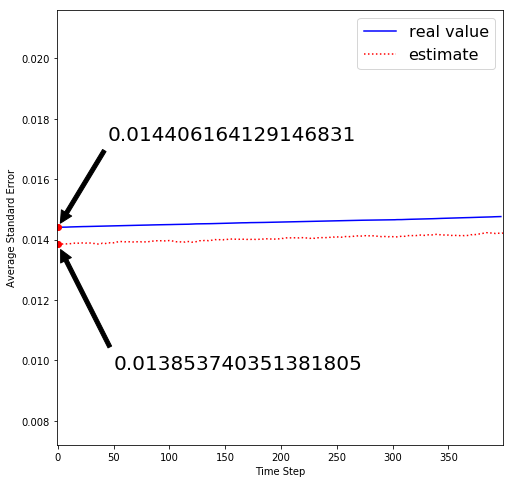

0.014406164129146831 0.013853740351381805 0.0383463476337432


In [10]:
### add Annotating text
Ave_sigma=np.sum(sigma,axis=1)/I
Ave_sigma_hat=np.sum(sigma_hat,axis=1)/I
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.annotate(Ave_sigma[a], xy=(0,Ave_sigma[a] ), xytext=(45,Ave_sigma[a]*1.2 ),size=20,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate(Ave_sigma_hat[0], xy=(0, Ave_sigma_hat[0]), xytext=(50, Ave_sigma_hat[0]*0.7),size = 20,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.set_ylim(Ave_sigma[a]*0.5,Ave_sigma[a]*1.5)
ax.set_xlim(-1,N-K)

### Create the figure

plt.xlabel('Time Step')
plt.ylabel('Average Standard Error')

plt.plot(Ave_sigma[a:b],label='real value',color='b',linestyle='-')
plt.plot(Ave_sigma_hat,label='estimate',color='r',linestyle=':')
line,=ax.plot(0,Ave_sigma[a],'r-o')
line,=ax.plot(0,Ave_sigma_hat[0],'r-o')
plt.legend(fontsize=16,loc=1)
plt.show()
print(Ave_sigma[a],Ave_sigma_hat[0],(Ave_sigma[a]-Ave_sigma_hat[0])/Ave_sigma[a])

-0.05183287133238561 0.16671761537010304 (401, 20000)


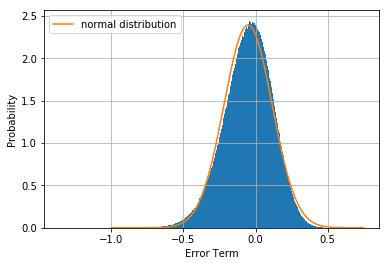

In [11]:
# 到期时所有模拟指数水平的频率直方图
# 误差项的频率分布图
import matplotlib.pyplot as plt
%matplotlib inline
error=np.log(sigma_hat[:,:])-np.log(sigma[a-1:b+2,:])
plt.hist(error.flatten(), bins=1000,density=True)
plt.grid(True)
plt.xlabel('Error Term')
plt.ylabel('Probability')
print(np.average(error),np.std(error,ddof=1),error.shape)
def normfun(x,mu,sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf
x = np.arange(-1,0.75,0.001) 
#设定 y 轴，载入刚才的正态分布函数
y = normfun(x, np.average(error), np.std(error,ddof=1))
plt.plot(x,y,label='normal distribution')
#plt.axvline(x=bsm_call_value(S_0, K, T, r, sigma),ls=":",c="yellow")#真实值
#plt.axvline(x=np.average(error.flatten()),label='average line',ls="-",c="green")#样本均值
plt.legend(fontsize=10,loc=2)
plt.show()

In [12]:
#单位根检验
#第一步 构造ut
u_t=(error[1:,:]-error[:-1,:])
print(u_t[:,:1].shape)
#第二步 用ADF检验
t_adf=[]
for i in range(I):
    adf=sm.tsa.stattools.adfuller(u_t[:,i].flatten())
    t_adf.append(adf[1])
print(np.max(t_adf),np.min(t_adf),np.mean(t_adf),np.median(t_adf))

(400, 1)
0.058968236105172274 0.0 1.2012373456766496e-05 0.0


In [13]:
#P值表格
p_adf=[]
for i in range(I):
    adf=sm.tsa.stattools.adfuller(u_t[:,i].flatten())
    p_adf.append(adf[0])
print(np.max(p_adf),np.median(p_adf),np.min(p_adf),np.mean(p_adf))

-2.79516155577972 -19.020245304439655 -25.504117785069887 -16.460087415604093


In [ ]:
t_adf.sort()
n=0
while (t_adf[a]<0.01):
    n=n+1
print(a)

In [ ]:
##ut作图
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim(-0.5,0.5)

plt.hist(u_t.flatten(), bins=1000,density=True)
plt.grid(True)
plt.xlabel('u_t')
plt.ylabel('Probability')
x = np.arange(-0.25,0.25,0.001) 
#设定 y 轴，载入刚才的正态分布函数
y = normfun(x, np.average(u_t), np.std(u_t,ddof=1))
plt.plot(x,y,label='normal distribution')
#plt.axvline(x=bsm_call_value(S_0, K, T, r, sigma),ls=":",c="yellow")#真实值
#plt.axvline(x=np.average(error.flatten()),label='average line',ls="-",c="green")#样本均值
plt.legend(fontsize=10,loc=2)
plt.show()
print(np.average(u_t),np.std(u_t,ddof=1),u_t.shape)

In [ ]:
#Least Square
#The second step
Y=np.log(sigma_hat)
X=np.log(S_i[a-1:b+2])

In [ ]:
print(Y.shape,X.shape)
lrModel = LinearRegression()

In [ ]:
b=np.zeros(shape=(I,2))
t=np.zeros(shape=(I,2))
for i in range(I):
    model=sm.OLS(Y[:,i],sm.add_constant(X[:,i])).fit(cov_type='HC0')
    b[i]=model.params
    t[i]=model.tvalues
    
b0=[t[:,0],b[:,0]]
b1=[t[:,1],b[:,1]]


In [ ]:
np.array(b0).shape

In [ ]:
b0=np.array(b0)
b1=np.array(b1)
B0=b0.T[np.lexsort(b0)]
B1=b1.T[np.lexsort(b1)]

In [ ]:
#theta_hat的20000次回归结果，从小到大排序
B1.shape

In [ ]:
end = time()
time_elapsed = end-start
print('The code run {:.0f}minutes {:.0f}seconds'.format(
        time_elapsed // 60, time_elapsed % 60))